In [ ]:
!pip install python-terrier gensim

In [ ]:
import pyterrier as pt
if not pt.started():
  pt.init()

import pandas as pd
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.max_rows', 200)

In [3]:
pt.list_datasets()

,dataset,topics,topics_lang,qrels,corpus,corpus_lang,index,info_url
0,50pct,"[training, validation]",en,"[training, validation]",None,None,"[ex1, ex2]",None
1,antique,"[train, test]",en,"[train, test]",True,en,None,https://ciir.cs.umass.edu/downloads/Antique/readme.txt
2,vaswani,True,en,True,True,en,True,http://ir.dcs.gla.ac.uk/resources/test_collections/npl/
3,msmarco_document,"[train, dev, test, test-2020, leaderboard-2020]",en,"[train, dev, test, test-2020]",True,en,True,https://microsoft.github.io/msmarco/
4,msmarcov2_document,"[train, dev1, dev2, valid1, valid2, trec_2021]",en,"[train, dev1, dev2, valid1, valid2]",None,None,True,https://microsoft.github.io/msmarco/TREC-Deep-Learning.html
...,...,...,...,...,...,...,...,...
404,irds:trec-fair-2021,None,None,None,True,en,None,https://ir-datasets.com/trec-fair-2021.html
405,irds:trec-fair-2021/train,"[text, keywords, scope, homepage]",en,True,True,en,None,https://ir-datasets.com/trec-fair-2021.html#trec-fair-2021/train
406,irds:trec-fair-2021/eval,"[text, keywords, scope]",en,None,True,en,None,https://ir-datasets.com/trec-fair-2021.html#trec-fair-2021/eval
407,trec-deep-learning-docs,"[train, dev, test, test-2020, leaderboard-2020]",en,"[train, dev, test, test-2020]",True,en,True,https://microsoft.github.io/msmarco/


In [4]:
USERNAME = "2549408b"
PASSWORD = "335cf17f"

dotgov_50pct = pt.get_dataset("50pct", user=USERNAME, password=PASSWORD)
dotgov_topicsqrels =  pt.get_dataset("trec-wt-2004")#50% of TREC GOV corpus

In [5]:
indexref = dotgov_50pct.get_index()
index = pt.IndexFactory.of(indexref)


data.meta-0.fsomapfile:   0%|          | 0.00/50.1M [00:00<?, ?iB/s]

data.direct.bf:   0%|          | 0.00/263M [00:00<?, ?iB/s]

data.document.fsarrayfile:   0%|          | 0.00/13.1M [00:00<?, ?iB/s]

data.inverted.bf:   0%|          | 0.00/273M [00:00<?, ?iB/s]

data.lexicon.fsomapfile:   0%|          | 0.00/168M [00:00<?, ?iB/s]

data.lexicon.fsomaphash:   0%|          | 0.00/0.99k [00:00<?, ?iB/s]

data.lexicon.fsomapid:   0%|          | 0.00/7.80M [00:00<?, ?iB/s]

data.meta.idx:   0%|          | 0.00/6.16M [00:00<?, ?iB/s]

data.meta.zdata:   0%|          | 0.00/19.2M [00:00<?, ?iB/s]

data.properties:   0%|          | 0.00/4.13k [00:00<?, ?iB/s]

In [6]:
print(index.getCollectionStatistics())

Number of documents: 807775
Number of terms: 2043788
Number of postings: 177737957
Number of fields: 0
Number of tokens: 572916194
Field names: []
Positions:   false



In [7]:
#three sets of topics: hp,np,td
topics = dotgov_topicsqrels.get_topics(variant="hp")
topics.head(5) #variant is just a diff set of qrels

Web2004.query.stream.trecformat.txt:   0%|          | 0.00/15.3k [00:00<?, ?iB/s]

04.topic-map.official.txt:   0%|          | 0.00/2.53k [00:00<?, ?iB/s]

,qid,query
0,6,philadelphia streets
1,7,togo embassy
2,9,baltimore
3,17,secure linux
4,29,grand canyon monitoring and research center


In [8]:
 retr= pt.BatchRetrieve(index, wmodel="TF_IDF")#tdidf retreiver
 qrels = dotgov_topicsqrels.get_qrels(variant='hp') #evaluating tfidf retr

04.qrels.web.mixed.txt:   0%|          | 0.00/1.90M [00:00<?, ?iB/s]

In [9]:
res = retr.transform(topics) 
eval = pt.Utils.evaluate(res, qrels, metrics=["map"]) #to evalute the results #mean average precision
eval

{'map': 0.20894845478512017}

In [10]:
pt.Experiment(
    [retr], #our model Tf-IDF A(B) 
     dotgov_topicsqrels.get_topics(variant='hp'), #per-defined query in the dataset c
     dotgov_topicsqrels.get_qrels(variant='hp'), #pre -defined query values in the dataset D
     eval_metrics=['map']
) #A(B) - C(D) #to evaluate one or more retreival systems at once

,name,map
0,BR(TF_IDF),0.208948


In [11]:
#dataset
dataset=pt.get_dataset("trec-wt-2004")
#defining three models
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF") #retr
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
pl2 = pt.BatchRetrieve(index, wmodel="PL2")

In [15]:
#for all variants
pt.Experiment(
    [tfidf, bm25,pl2],
    dataset.get_topics(variant="all"),
    dataset.get_qrels(variant="all"),
    eval_metrics=["map"],
    round={"map" : 4},
    baseline=0,
    names=["TF_IDF_ALL", "BM25_ALL","PL2_ALL"]
) #PL2 is the most effective weighting model in terms of average MAP  across the 2 topic sets

,name,map,map +,map -,map p-value
0,TF_IDF_ALL,0.2422,NaN,NaN,NaN
1,BM25_ALL,0.2435,43.0,62.0,0.770693
2,PL2_ALL,0.2446,73.0,92.0,0.796196


In [13]:
#interpolated recall precision graphs
pt.Experiment(
    [tfidf, bm25,pl2],
    dataset.get_topics(variant="hp"),
    dataset.get_qrels(variant="hp"),
    eval_metrics=["iprec_at_recall"],
    round={"iprec_at_recall" : 4},
    
    names=["TF_IDF_HP", "BM25_HP","PL2_HP"]
) 

,name,IPrec@0.0,IPrec@0.1,IPrec@0.2,IPrec@0.3,IPrec@0.4,IPrec@0.5,IPrec@0.6,IPrec@0.7,IPrec@0.8,IPrec@0.9,IPrec@1.0
0,TF_IDF_HP,0.213123,0.213123,0.213123,0.213123,0.213123,0.213123,0.206457,0.206457,0.206457,0.206457,0.206457
1,BM25_HP,0.222756,0.222756,0.222756,0.222756,0.222756,0.222756,0.216090,0.216090,0.216090,0.216090,0.216090
2,PL2_HP,0.229183,0.229183,0.229183,0.229183,0.229183,0.229183,0.222516,0.222516,0.222516,0.222516,0.222516


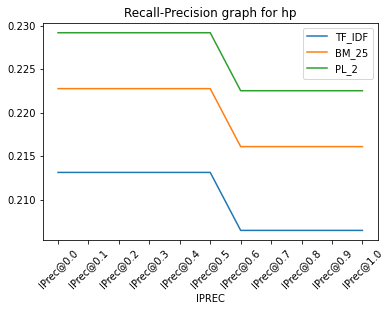

In [14]:
TF_IDF_hp=[0.213123,	0.213123,	0.213123,	0.213123,	0.213123,	0.213123,	0.206457,	0.206457,	0.206457,	0.206457,	0.206457]
BM_25_hp=[0.222756,	0.222756,	0.222756	,0.222756,	0.222756,	0.222756,	0.216090,	0.216090	,0.216090	,0.216090,	0.216090]
PL_2_hp=[0.229183,	0.229183,	0.229183	,0.229183	,0.229183,	0.229183	,0.222516	,0.222516,	0.222516,	0.222516,	0.222516]
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
ax.plot(TF_IDF_hp, label="TF_IDF")
ax.plot(BM_25_hp, label="BM_25")
ax.plot(PL_2_hp,label="PL_2")
ax.set_xlabel('IPREC')
#plt.yticks([0.1,0.2,0.3,0.4,0.5])
plt.xticks([0,1,2,3,4,5,6,7,8,9,10],['IPrec@0.0','IPrec@0.1','IPrec@0.2','IPrec@0.3','IPrec@0.4','IPrec@0.5','IPrec@0.6','IPrec@0.7','IPrec@0.8','IPrec@0.9','IPrec@1.0'],
           rotation=45)
plt.title("Recall-Precision graph for hp")
ax.legend()
plt.savefig("Recall-precision graph for hp")
plt.show()

In [16]:
#query expansion on the PL2 (best weighting model of all three)
bo1 = pt.rewrite.Bo1QueryExpansion(index)
pl2 = pt.BatchRetrieve(index, wmodel="PL2")
pipelineQE = pl2 >> bo1 >> pl2 

In [17]:
pt.Experiment([pl2, pipelineQE],
            dataset.get_topics(variant="all"),
            dataset.get_qrels(variant="all"),
            ["map"],
            round={"map" : 4},
            baseline=0,
    
            names=["PL2_HP","pipleline_PL2_HP"]
            )

,name,map,map +,map -,map p-value
0,PL2_HP,0.2446,NaN,NaN,NaN
1,pipleline_PL2_HP,0.2512,69.0,92.0,0.509105


In [20]:
data=pt.Experiment([pl2, pipelineQE],
            dataset.get_topics(variant="td"),
            dataset.get_qrels(variant="td"),
            ["map"],
            
            perquery=True,
    
            names=["pl2_td","piplelineBM_td"]
            )

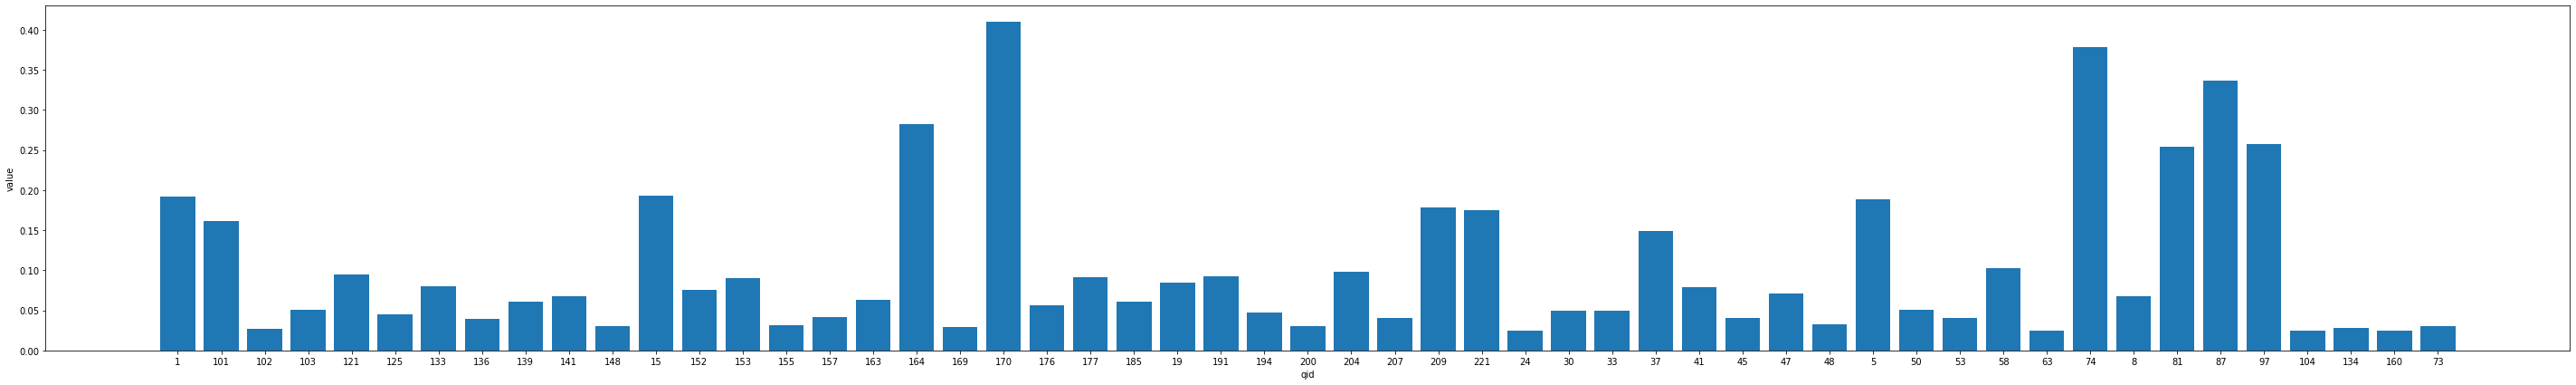

In [22]:
mask = data["value"] > 0.02

y = data.loc[mask, "value"].tolist()
x= data.loc[mask, "qid"].tolist()

plt.bar(x,y)
plt.xlabel("qid")
plt.ylabel("value")

plt.rcParams["figure.figsize"] = (50,20)

**Word Embeddings**

Word2vec based query expansion model. Similar words has similar embedding vectors

Gensim- Python toolkit for Word2vec model

In [23]:
import gensim.downloader as api
%time model = api.load("glove-wiki-gigaword-300")
#pre-trained word2vec


[==================================================] 100.0% 376.1/376.1MB downloaded
CPU times: user 3min 56s, sys: 16 s, total: 4min 12s
Wall time: 4min 31s


In [24]:
emb = model.get_vector("capitalism")
print(emb.shape)
print(emb)

(300,)
[ 0.029571  -0.26027    0.27638   -0.52242   -0.15456    0.021228
 -0.19844    0.52877    0.98453   -0.7506     0.1905     0.16699
 -0.41054    0.22643    0.69543   -0.69814    0.70978   -0.08798
  0.28759    0.61957   -0.094915   0.45109    0.76162   -0.16713
  0.58875   -0.21896    0.42419    0.43977   -0.17451    0.16858
  0.041086   0.31843    0.29785   -0.42722    0.010953   0.14435
  0.36068   -0.30447    0.4224    -0.23193    0.15015    0.30814
 -0.045377  -0.22061    0.061524  -0.049047   0.11191    0.44138
 -0.88641   -0.28218   -0.071945  -0.57919    0.36774   -0.2149
  0.37954   -0.17658   -0.017091   0.034995  -0.29899    0.20899
  0.6783    -0.27885   -0.40205   -0.96349   -0.75525    0.74291
  0.030328   0.052626   0.098442   0.24224    0.148      0.1498
 -0.38691   -0.17857    0.51182    0.10077   -0.41855    0.46617
  0.19613    0.42988    0.056099  -0.5332     0.37639    0.3882
  0.40806   -0.25835    0.5622     0.59752   -0.14522    0.10658
  0.042123  -0.5431 

In [25]:
model.most_similar("capitalism") #based on cosine similarity of the embeddings

[('communism', 0.6336767077445984),
 ('socialism', 0.6222169399261475),
 ('liberalism', 0.612514853477478),
 ('capitalist', 0.6099783182144165),
 ('imperialism', 0.5746486186981201),
 ('consumerism', 0.5485059022903442),
 ('feudalism', 0.536788821220398),
 ('globalization', 0.5319066047668457),
 ('crony', 0.5270956754684448),
 ('laissez-faire', 0.5063261389732361)]

In [28]:
#Word2Vec based Query Expansion
def update_query(q):
  terms=q["query"].split(" ")
  #print(len(terms))
  #print(terms)
  newterm= ""
  for t in terms:

    
    #try:

    similar=model.most_similar(t,topn=1)
      
      #print(t)
      #print(similar[0][0],similar[0][1])
    newterm= "".join((newterm,t,'^5 '," "))
    #print(newterms)
    newterm="".join((newterm,similar[0][0] ,'^' ,str(similar[0][1])," ")) 
    #print(newterms)
      
    #except:

      #newterms=newterms.join((" ",t,'^5 '," "))
      

      #continue
    

  return newterm
  
#transformer
pnew=pt.apply.query(update_query) >> pt.BatchRetrieve(index, wmodel="PL2")

In [30]:
td_topics=dataset.get_topics(variant="td")
#td_topics
custom_res=pnew.transform(td_topics)
#custom_expand=pt.experiment(custom_res,query,metrics=["map"],perquery=True)
custom_res

,qid,docid,docno,rank,score,query_0,query
0,1,98060,G03-12-4155229,0,18.008587,electoral college,electoral^5 election^0.7704978585243225 college^5 school^0.7110487222671509
1,1,184383,G06-33-3247042,1,17.519994,electoral college,electoral^5 election^0.7704978585243225 college^5 school^0.7110487222671509
2,1,98405,G03-14-0727242,2,17.291737,electoral college,electoral^5 election^0.7704978585243225 college^5 school^0.7110487222671509
3,1,110098,G03-56-3077214,3,17.275708,electoral college,electoral^5 election^0.7704978585243225 college^5 school^0.7110487222671509
4,1,297788,G10-47-2751220,4,17.275708,electoral college,electoral^5 election^0.7704978585243225 college^5 school^0.7110487222671509
...,...,...,...,...,...,...,...
74960,221,206417,G07-19-1023034,995,6.916445,homeland security,homeland^5 chertoff^0.510805606842041 security^5 forces^0.5520374774932861
74961,221,111690,G03-62-4024225,996,6.915971,homeland security,homeland^5 chertoff^0.510805606842041 security^5 forces^0.5520374774932861
74962,221,41590,G01-24-1005402,997,6.914929,homeland security,homeland^5 chertoff^0.510805606842041 security^5 forces^0.5520374774932861
74963,221,717626,G26-51-2929053,998,6.912768,homeland security,homeland^5 chertoff^0.510805606842041 security^5 forces^0.5520374774932861


In [33]:
pnew.search("anime")

,qid,docid,docno,rank,score,query_0,query
0,1,353157,G12-52-1290791,0,7.200792,anime,anime^5 manga^0.7752507328987122
1,1,128508,G04-26-1816869,1,7.117641,anime,anime^5 manga^0.7752507328987122
2,1,150826,G05-09-1101034,2,7.114356,anime,anime^5 manga^0.7752507328987122
3,1,717360,G26-50-1380134,3,7.066404,anime,anime^5 manga^0.7752507328987122
4,1,316918,G11-19-3442287,4,7.024786,anime,anime^5 manga^0.7752507328987122
...,...,...,...,...,...,...,...
995,1,802597,G29-80-2695032,995,4.911678,anime,anime^5 manga^0.7752507328987122
996,1,382774,G13-59-4187242,996,4.911056,anime,anime^5 manga^0.7752507328987122
997,1,87710,G02-77-0256818,997,4.911003,anime,anime^5 manga^0.7752507328987122
998,1,583542,G20-95-0276510,998,4.911003,anime,anime^5 manga^0.7752507328987122


In [35]:
pt.Experiment([pl2,pipelineQE ,pnew],
            dataset.get_topics(variant="td"),
            dataset.get_qrels(variant="td"),
            ["map"],
            
            
    
            names=["pl2","bo1","pipleline"]
            ) 
#query expansion based on word2vec improves MAP

,name,map
0,pl2,0.069525
1,bo1,0.067078
2,pipleline,0.071624
